# Exercise 01 - Linear Regression

## Data generation

Generate a training data set for regression consisting of $N = 100$ points. The input values $\{x_n\}_{n=1}^N$ are generated uniformly in the interval $(0,1)$ and the corresponding target values $\{t_n\}_{n=1}^N$ are obtained by first computing the corresponding values of the function $abx^{a-1}(1 - x^a)^{b-1}$, with $a=2$ and $b=5$, and, then, by adding some random noise $\epsilon$ with a Gaussian distribution having mean $\mu = 0$ and standard deviation $\sigma = 0.3$, $\epsilon \sim N(\mu, \sigma)$: $$t_n = abx^{a-1}(1 - x^a)^{b-1} + \epsilon_n \ \text{with}\ a=2,\ b=5\ \text{and}\ \epsilon_n \sim N(\mu, \sigma)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

The first thing to do is to create functions that return the real value of $f(x) = abx^{a-1}(1 - x^a)^{b-1}$ (with fixed $a$ and $b$) and the noised value $g(x) = f(x) + \epsilon$.

In [2]:
def f(x, a=2, b=5):
    return a*b*(x**(a-1))*((1-x**a)**(b-1))
    #return math.sin(2*math.pi*x)

In [3]:
def f_noise(x, mean=0.0, sd = 0.3):
    return f(x) + np.random.normal(mean, sd)

Now, we'll just create a dataset by calculating the value of $g(x)$ for 100 equally-spaced points in the interval (0,1)

In [4]:
def generate_dataset(inf = 0, sup = 1, n_points=100):
    step = round((sup - inf)/n_points, 2)
    points = []
    for x in range(100):
        points.append(x*step)
    return [(x, f_noise(x)) for x in points]

def save_dataset(dataset, outputfile):
    with open(outputfile, 'w') as f:
        for line in dataset:
            f.write(str(line[0]) + '\t' + str(line[1]) + '\n')

In [5]:
dataset = generate_dataset()
save_dataset(dataset, 'data.tsv')

Here is a sample of the dataset we get:

In [6]:
dataset[:10]

[(0.0, 0.13740357137949347),
 (0.01, -0.7739044922154135),
 (0.02, 0.8031161088009965),
 (0.03, 0.03932126286498072),
 (0.04, 0.2863310392878493),
 (0.05, -0.037273588732157636),
 (0.06, 0.8183343025326422),
 (0.07, 0.9092288795657522),
 (0.08, 0.47559279990776254),
 (0.09, 1.1279837076458692)]

And here is the figure we get by plotting the data:

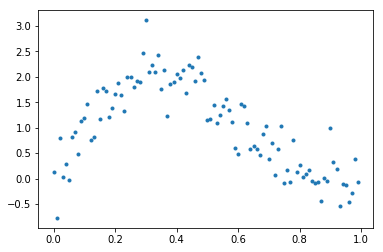

In [7]:
plt.plot([x[0] for x in dataset], [x[1] for x in dataset], '.')
plt.show()

## Curve fitting

Fit the data with a polynomial function of the form $$y_M(x,w) = w_0 + w_1x + w_2x^2 + \cdots + w_Mx^M = \sum\limits_{j=0}^{M}{w_jx^j},$$ in which M is the order of the polynomial. The polynomial coefficients are collected in vector $w$.

The fit must be done by minimising, independently, two error functions that measure, for any given value of $w$, the misfit between function $y_M(x, w)$ and the training data. That is:

* $E_{OLS}(w, M) = \frac{1}{2} \sum\limits_{n=1}^{N} (y_M(x,w) - t_n)^2$ 
* $E_{RIDGE}(w, M, \lambda) = \frac{1}{2} \sum\limits_{n=1}^{N} (y_M(x,w) - t_n)^2 + \frac{\lambda}{2}\|w\|$

In the first case, you must select the order $M$ of the polynomial using $S$-fold cross-validation, for $S=3$ and for $S=N$ (leave-one-out cross-validation, LOO). In the second case, let $M$ be fixed and select the regularisation coefficient $\lambda$, again using $K$-fold cross-validation, for $K=3$ and for $K=N$. 

### General functions

First, we need a function to create a matrix $X \in \mathbb{R}^{N \times M}$ with the values of the variables $x$ from the expression $y_M(x, w)$, i.e. $X$ is the matrix with $x_{ij} = x_i^j$, where $N$ is the number of datapoints we have, $M$ is the degree of the polynomial $y_M(x,w)$ and $x_i$ is the value from the $i$th-line from our dataset

In [8]:
def generate_matrix(data, m):
    return [[line[0]**i for i in range(m+1)] + [line[1]] for line in data]

Now, we need a function that calculates the value of the weights $w*$ of the model from the formula $w^* = (X^TX)^{-1}X^TY$ (For ordinary least squares) or $w^* = (X^TX + \lambda i)^{-1}X^TY$ (for ridge regression)

In [9]:
def update_weights(X, t, method='OLS', lambd = 0):
    if method == 'OLS':
        xxt = np.dot(np.transpose(X), X)
        inv = np.linalg.inv(xxt)
        X_factor = np.dot(inv, np.transpose(X))
        return np.dot(X_factor, t)
    else:
        xxt = np.dot(np.transpose(X), X)
        xxtlamb = np.add(xxt, np.dot(lambd, np.eye(len(xxt))))
        inv = np.linalg.inv(xxtlamb)
        X_factor = np.dot(inv, np.transpose(X))
        return np.dot(X_factor, t)

The next function is used to calculate the least squares errors between two inputs: the outputs of the predictions and 
the targets.

In [10]:
def calculate_least_squares_error(predictions, targets):
    return sum([(x - t)**2 for x,t in zip(predictions, targets)])/2

def calculate_least_squares_regularized(predictions, targets, lambd, weights):
    return calculate_least_squares_error(predictions, targets) + (lambd/2)*np.linalg.norm(weights)

Now we need a function that takes as input a training set and a test set, finds the model parameters for the training set and outputs the predictions and the least squares error for the test set.

In [11]:
def fit_and_find_error(X_train, y_train, X_test, y_test, method='OLS', lambd=0):
    weights = update_weights(X_train, y_train, method, lambd)
    predictions = [np.dot(weights, line) for line in X_test]
    if method=='OLS':
        return predictions, calculate_least_squares_error(predictions, y_test)
    else:
        return predictions, calculate_least_squares_regularized(predictions, y_test, lambd, weights)

And to finish, we need a function that splits the data in K-folds and outputs a list of those folds.

In [12]:
def k_fold_split(data, k):
    folds = []
    fold_size = int(len(data)/k)
    lower = 0
    upper = fold_size
    n_data = 0
    for n_fold in range(k):
        fold = [data[x] for x in range(lower, upper)]
        n_data += len(fold)
        
        # updating the boundaries
        lower = upper
        upper += fold_size
        
        # making sure that upper <= len(data)
        upper = min(upper, len(data))
        
        if n_data != len(data) and n_fold == k-1:
            fold += data[n_data:len(data)]
        
        folds.append(fold)
    return folds    

6.16568706224


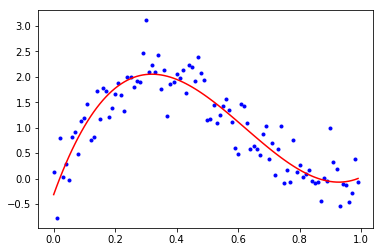

In [13]:
mat = generate_matrix(dataset, 3)

X_train = np.array([x[:-1] for x in mat])
y_train = np.array([x[-1]  for x in mat])

w = update_weights(X_train, y_train)

pred = [np.dot(w, line) for line in X_train]
print(calculate_least_squares_error(pred, y_train))
plt.plot([x[0] for x in dataset],[x[1] for x in dataset], 'b.', [x[0] for x in dataset], pred, 'r')
plt.show()

### Ordinary Least Squares

Now, we need to find the optimal value of M. For that, we use cross-validation. The process is:
* Split the data in K folds.
* Iterate through the possible values of M (from 0 to len(data)).
    * Iterate through the folds, taking one fold to be the test set and the others to be the train set (i.e. Every fold must be used as test set once).
        * Fit a model for the current training set and measure the error in the test set.
    * After finishing iterating through the folds, calculate the mean of the errors.
* After doing this for every value of M, find the value with the least mean error.

In [14]:
def OLS(dataset, max_M = 100, k = 3):
    mean_errors = []
    data = list(dataset)
    random.shuffle(data)
    for M in range(max_M + 1):
        matrix_data = generate_matrix(data, M)
        folds = k_fold_split(matrix_data, k)
        errors = []
        for i,fold in enumerate(folds):
            test = fold
            train = [el for n,tfold in enumerate(folds) for el in tfold if n != i]
            
            X_train = np.array([line[:-1] for line in train])
            y_train = np.array([line[-1] for line in train])
            
            X_test = np.array([line[:-1] for line in test])
            y_test = np.array([line[-1] for line in test])
            
            pred, error = fit_and_find_error(X_train, y_train, X_test, y_test)
            errors.append(error)
        mean_errors.append(math.log10(sum(errors)/(int(len(data)/k))))
    plt.plot(mean_errors)
    plt.show()
    return mean_errors.index(min(mean_errors))

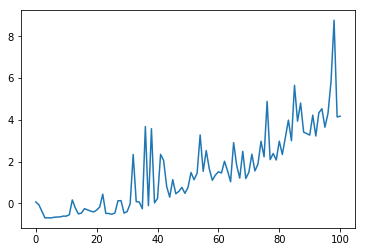

Best value of M using k=3 folds: 5


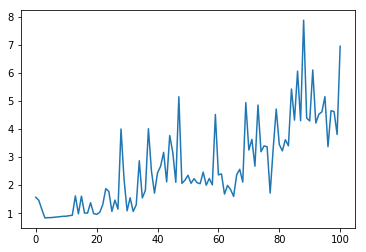

Best value of M using k=100 folds: 3


In [15]:
M_opt_3 = OLS(dataset, max_M=100, k=3)
print("Best value of M using k=3 folds: {}".format(M_opt_3))

M_opt_100 = OLS(dataset, max_M=100, k=100)
print("Best value of M using k=100 folds: {}".format(M_opt_100))

### Ridge Regression

Now, given the value found for M, we must find the best value for $\lambda$. For that, we use cross-validation. The process is:
* Split the data in K folds.
* Iterate through the possible values of $\lambda$ (Discussed a bit further).
    * Iterate through the folds, taking one fold to be the test set and the others to be the train set (i.e. Every fold must be used as test set once).
        * Fit a model for the current training set and measure the error in the test set.
    * After finishing iterating through the folds, calculate the mean of the errors.
* After doing this for every value of $\lambda$, find the value with the least mean error.

This process is the same as the OLS, but now we need to define the possible values for the continuous variable $\lambda$. For that, we will analyze what happens to the error for a few values of $\lambda$, using the whole dataset.

In [16]:
def ridge(dataset, possible_lambdas, k=3, M=3):
    mean_errors = []
    data = list(dataset)
    random.shuffle(data)
    for lambd in possible_lambdas:
        matrix_data = generate_matrix(data, M)
        folds = k_fold_split(matrix_data, k)
        errors = []
        for i,fold in enumerate(folds):
            test = fold
            train = [el for n,tfold in enumerate(folds) for el in tfold if n != i]

            X_train = np.array([line[:-1] for line in train])
            y_train = np.array([line[-1] for line in train])

            X_test = np.array([line[:-1] for line in test])
            y_test = np.array([line[-1] for line in test])

            pred, error = fit_and_find_error(X_train, y_train, X_test, y_test, method='ridge', lambd=lambd)
            errors.append(error)
        mean_errors.append(sum(errors)/k)
    plt.plot(mean_errors)
    plt.show()
    return mean_errors.index(min(mean_errors))

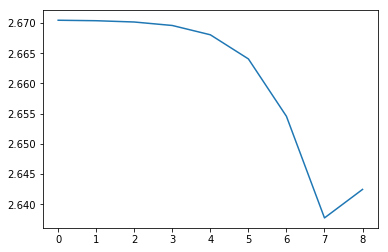

7


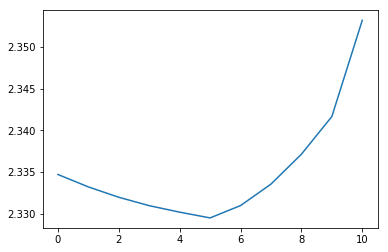

5


In [22]:
poss_1 = [-15, -14, -13, -12, -11, -10, -9, -8, -7]
l_opt_3 = ridge(dataset, [math.exp(x) for x in poss_1])
print(l_opt_3)

l_opt_3 = ridge(dataset, [x*math.exp(poss_1[l_opt_3]) for x in [0.1, 0.2, 0.3, 0.4, 0.5,1, 1.25, 1.5, 1.75, 2, 2.5]])
print(l_opt_3)



So the best value for $\lambda$ found from this analysis is about $e^{-8}$ (It is important to note that in the ridge function, we randomize the dataset. Given the randomization that we choose, the intervals used to choose the value of $\lambda$ might be wrong).

### Calculating model parameters

Now, in possession of $M$ and $\lambda$, we can train our model and find its parameters

In [24]:
mat = generate_matrix(dataset, 11)
print('Weights for OLS:')
print(update_weights([line[:-1] for line in mat], [line[-1] for line in mat]))

Weights for OLS:
[ -1.14648916e-01   6.06472142e+00   1.78831346e+02  -1.99905056e+03
   8.42700870e+03  -8.31391488e+03  -5.53355790e+04   2.34767439e+05
  -4.22022130e+05   4.08387021e+05  -2.07912142e+05   4.38168885e+04]


In [25]:
print('Weights for Ridge regression:')
print(update_weights([line[:-1] for line in mat], [line[-1] for line in mat], method='ridge', lambd=math.exp(-8)))

Weights for Ridge regression:
[ -0.1463597   12.91753852 -16.7964766   -7.89580119   3.3022545
   7.31370115   5.66773531   1.86089851  -1.50409199  -3.06761889
  -2.36830238   0.544724  ]
